In [1]:
import os
import glob
import datetime
import numpy as np
from astropy.io import fits
from photutils import DAOStarFinder, CircularAperture
import photutils.psf
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.signal import peak_widths
import astropy.units as u
import pandas as pd
from scipy import stats
from calibFuncs import * #sortData, starLocate, nircEPSF, calcBinDist

In [2]:
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\nirc2-trapezium'
NIRC2_datasets = sortData(datadir, instrument='NIRC2', filesufx='*.fit*')

  2%|█▋                                                                                | 3/145 [00:00<00:05, 26.09it/s]

sorting individual images


100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 16598.78it/s]

sorting unique datasets into lists


In [3]:
uniques = sortData(datadir, instrument='NIRC2', filesufx='*.fit*', returntab=True)

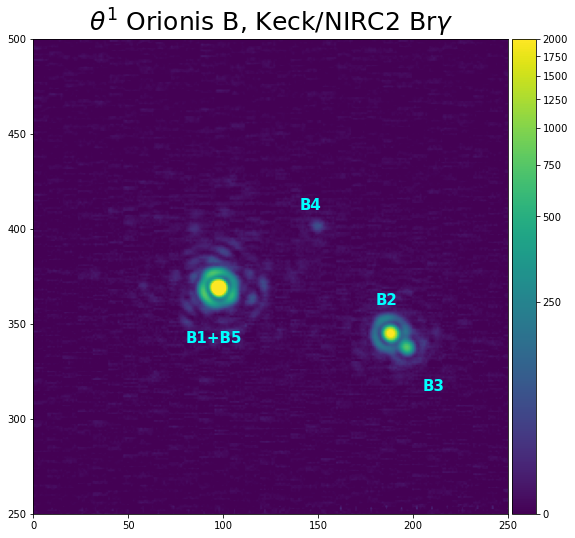

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(9,9))
ax = plt.gca()

data, head = fits.getdata(NIRC2_datasets[14][3], header=True)
wave = head['FWONAME']
if wave == 'Br_gamma':
    wave = 'Br$\gamma$'

im = ax.imshow(data, norm=ImageNormalize(stretch=AsinhStretch(a=0.05), vmin=0, vmax=2000), origin='lower')
ax.set_xlim(0,250)
ax.set_ylim(250,500)
plt.annotate(xy=[80,340], s='B1+B5', c='cyan', size=15, weight='bold')
plt.annotate(xy=[140,410], s='B4', c='cyan', size=15, weight='bold')
plt.annotate(xy=[180,360], s='B2', c='cyan', size=15, weight='bold')
plt.annotate(xy=[205,315], s='B3', c='cyan', size=15, weight='bold')
plt.title(r'$\theta^1$ Orionis B, Keck/NIRC2 '+wave, size=25)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.savefig('tet1oriB_NIRC2.png', dpi=150, transparent=True)


Choose a reference star image to create a reference PSF from


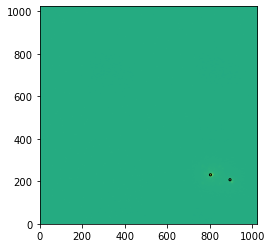

    xcentroid         ycentroid           roundness     
----------------- ------------------ -------------------
895.7540943433828 207.02645703238207 0.06888612477855645
803.6859095432949  230.3096867701864 0.07933102745959958
input the 0 indexed integer of your target from the table above: 1
target star is at  803 , 230  at FWHM 5.7135006295350195


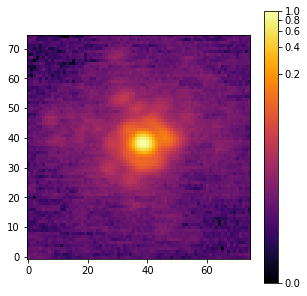

Select your target system to fit positions to


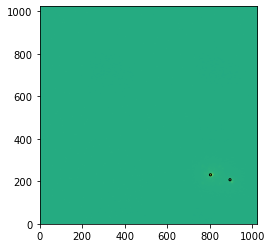

    xcentroid         ycentroid           roundness     
----------------- ------------------ -------------------
895.7540943433828 207.02645703238207 0.06888612477855645
803.6859095432949  230.3096867701864 0.07933102745959958
input the 0 indexed integer of your target from the table above: 0
target star is at  895 , 207  at FWHM 5.604529857896182
Stars found at positions
       x_0              y_0       
----------------- ----------------
38.62333926165128 37.9043197215002
       x_0               y_0       
----------------- -----------------
44.40336183952602 28.04324759189479

114.91700695999285 mas +/- 0.04864814433196933 mas
210.23915083588508 +/- 0.815677031005953
Choose a reference star image to create a reference PSF from


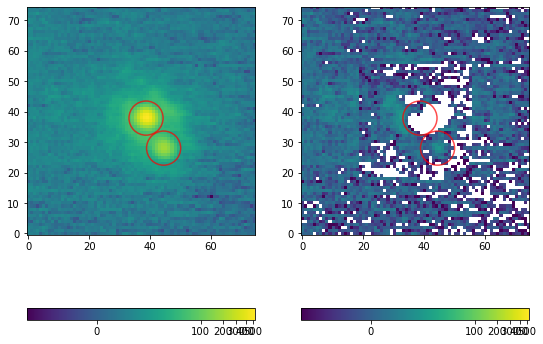

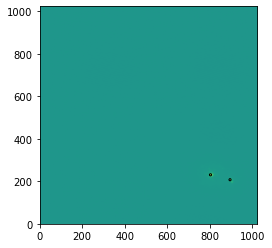

    xcentroid         ycentroid           roundness     
----------------- ------------------ -------------------
895.8930149371437  207.0534029075392 0.06544504854272098
803.8491155408852 230.30477749748977 0.07994032181042704
input the 0 indexed integer of your target from the table above: 1
target star is at  803 , 230  at FWHM 5.427396843197812


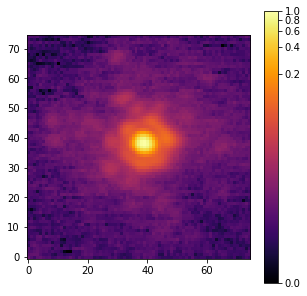

Select your target system to fit positions to


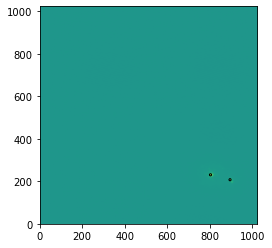

    xcentroid         ycentroid           roundness     
----------------- ------------------ -------------------
895.8930149371437  207.0534029075392 0.06544504854272098
803.8491155408852 230.30477749748977 0.07994032181042704
input the 0 indexed integer of your target from the table above: 0
target star is at  895 , 207  at FWHM 5.3063612863331855
Stars found at positions
       x_0               y_0       
----------------- -----------------
38.86457747901642 37.98421506158777
       x_0               y_0        
----------------- ------------------
44.78037453099889 28.052336425719886

115.57342349454662 mas +/- 0.10147823812305089 mas
210.3108619518832 +/- 0.709624125518455
Choose a reference star image to create a reference PSF from


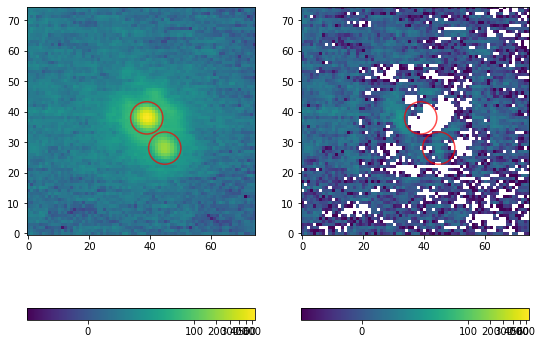

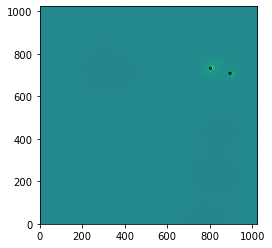

    xcentroid         ycentroid          roundness     
----------------- ----------------- -------------------
896.2973538221709   708.26730829296 0.09939614611833517
804.1706831259245 731.6919465265094 0.11943681344478167
input the 0 indexed integer of your target from the table above: 1
target star is at  804 , 731  at FWHM 6.063203392956666


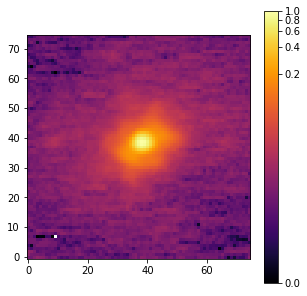

Select your target system to fit positions to


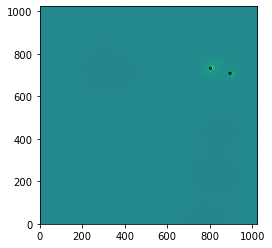

    xcentroid         ycentroid          roundness     
----------------- ----------------- -------------------
896.2973538221709   708.26730829296 0.09939614611833517
804.1706831259245 731.6919465265094 0.11943681344478167
input the 0 indexed integer of your target from the table above: 0
target star is at  896 , 708  at FWHM 6.184244539201359
Stars found at positions
       x_0               y_0       
----------------- -----------------
38.30663124514615 37.91894452112692
found fewer than 2 stars! re-enter threshold? >20
Stars found at positions
       x_0               y_0       
----------------- -----------------
38.30663124514615 37.91894452112692
       x_0                y_0        
------------------ ------------------
44.173782543662305 27.961277974589215

114.8971621248697 mas +/- 0.16703911426975762 mas
210.49802923751167 +/- 1.115727857548117
Choose a reference star image to create a reference PSF from


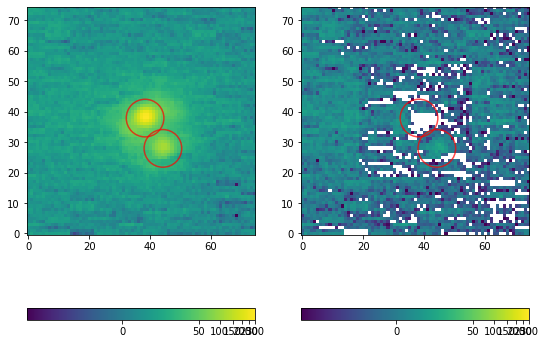

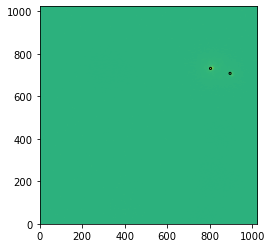

    xcentroid         ycentroid          roundness     
----------------- ----------------- -------------------
896.0661782527858 707.8512209694003 0.08756444375763169
803.9965008148166 731.1403551516445 0.09072339040972119
input the 0 indexed integer of your target from the table above: 1
target star is at  803 , 731  at FWHM 5.746806436779252


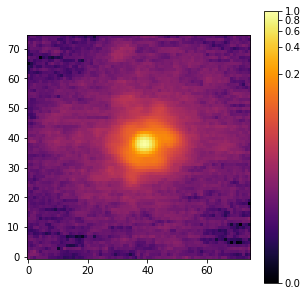

Select your target system to fit positions to


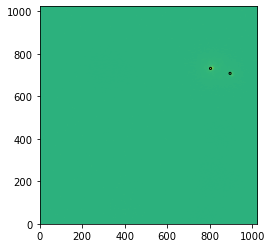

    xcentroid         ycentroid          roundness     
----------------- ----------------- -------------------
896.0661782527858 707.8512209694003 0.08756444375763169
803.9965008148166 731.1403551516445 0.09072339040972119
input the 0 indexed integer of your target from the table above: 0
target star is at  896 , 707  at FWHM 5.870014038373142
Stars found at positions
       x_0               y_0        
----------------- ------------------
38.20951061055011 38.534235572674746
       x_0               y_0        
----------------- ------------------
43.96659685225843 28.596171084089693

114.73407454133923 mas +/- 0.07887487630976932 mas
210.15562411364343 +/- 0.9706300027561379
Choose a reference star image to create a reference PSF from


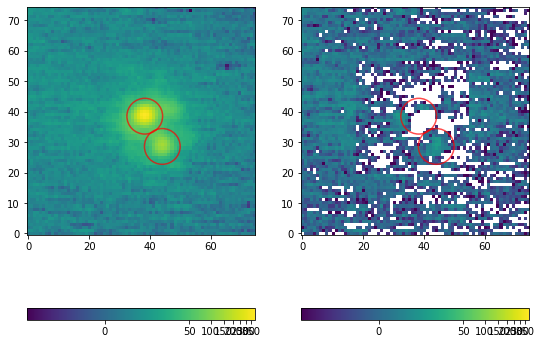

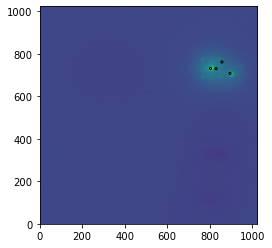

    xcentroid         ycentroid          roundness     
----------------- ----------------- -------------------
895.8218458111066 707.9017113624061 0.11140915927030323
830.0118510105705 730.1379311284746 0.17185694461217682
803.7358615452355 731.1899952152085 0.10801114535238751
857.6401439806865 761.5465114712398  0.0842897375449939
input the 0 indexed integer of your target from the table above: 2
target star is at  803 , 731  at FWHM 6.114119091810039


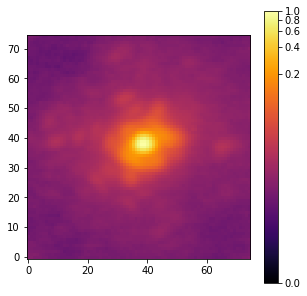

Select your target system to fit positions to


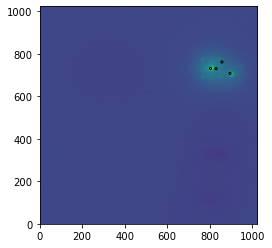

    xcentroid         ycentroid          roundness     
----------------- ----------------- -------------------
895.8218458111066 707.9017113624061 0.11140915927030323
830.0118510105705 730.1379311284746 0.17185694461217682
803.7358615452355 731.1899952152085 0.10801114535238751
857.6401439806865 761.5465114712398  0.0842897375449939
input the 0 indexed integer of your target from the table above: 0
target star is at  895 , 707  at FWHM 6.294718274185357
Stars found at positions
       x_0               y_0        
----------------- ------------------
38.72871701687252 38.456381196409374
      x_0               y_0        
---------------- ------------------
44.3645954651827 28.542247710514772

114.50295154435791 mas +/- 0.044751964490634094 mas
210.1153791693439 +/- 0.977883520015471
Choose a reference star image to create a reference PSF from


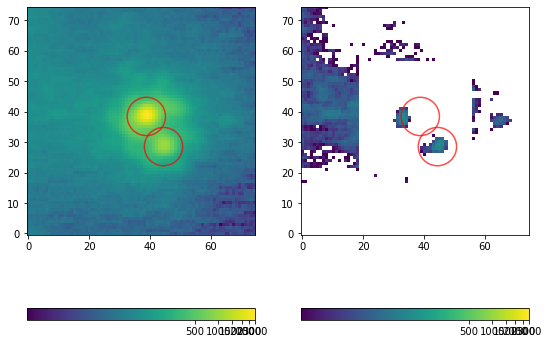

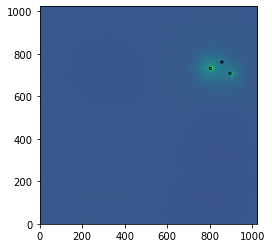

    xcentroid         ycentroid          roundness     
----------------- ----------------- -------------------
895.7459537682372  707.781805927738 0.11753720962018441
803.6786624503687 731.0526485119009 0.10269351119446125
857.5309117418689 761.1259959864923 0.04058860649625624
input the 0 indexed integer of your target from the table above: 1
target star is at  803 , 731  at FWHM 6.077671423832157


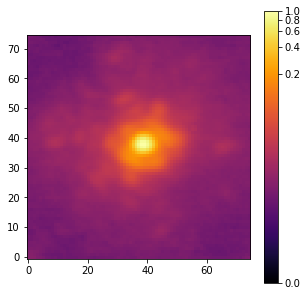

Select your target system to fit positions to


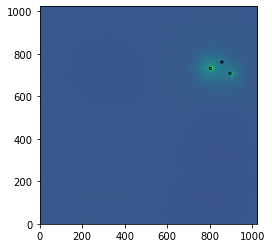

    xcentroid         ycentroid          roundness     
----------------- ----------------- -------------------
895.7459537682372  707.781805927738 0.11753720962018441
803.6786624503687 731.0526485119009 0.10269351119446125
857.5309117418689 761.1259959864923 0.04058860649625624
input the 0 indexed integer of your target from the table above: 0
target star is at  895 , 707  at FWHM 6.215334940117373
Stars found at positions
       x_0               y_0        
----------------- ------------------
38.59272420062048 38.339492909322544
       x_0               y_0       
----------------- -----------------
44.30743800173161 28.39876645490447

114.77390783653354 mas +/- 0.056463904266263104 mas
210.29453722332613 +/- 0.964059221997561
Choose a reference star image to create a reference PSF from


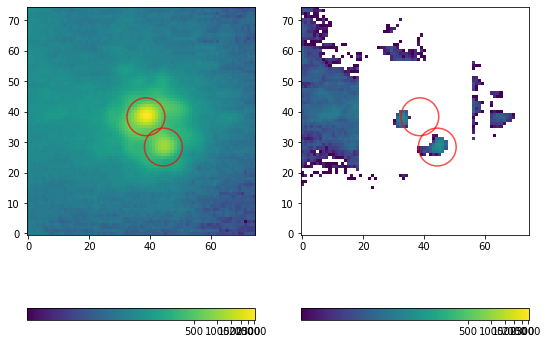

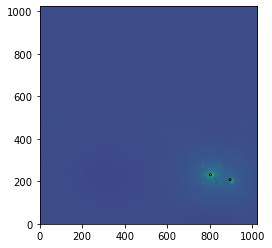

    xcentroid         ycentroid           roundness     
----------------- ------------------ -------------------
895.7791507045563 207.02705627894875  0.0667717687109443
803.7264653852261 230.29328810808155 0.07504287247177298
input the 0 indexed integer of your target from the table above: 1
target star is at  803 , 230  at FWHM 5.557799532315926


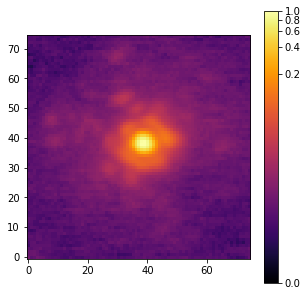

Select your target system to fit positions to


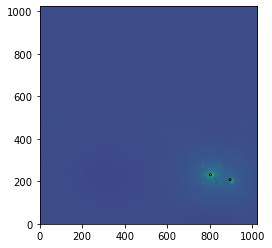

    xcentroid         ycentroid           roundness     
----------------- ------------------ -------------------
895.7791507045563 207.02705627894875  0.0667717687109443
803.7264653852261 230.29328810808155 0.07504287247177298
input the 0 indexed integer of your target from the table above: 0
target star is at  895 , 207  at FWHM 5.4222439816446695
Stars found at positions
       x_0             y_0      
----------------- --------------
38.71078290646955 37.93652416307
       x_0               y_0        
----------------- ------------------
44.59491831971991 27.968127816327886

115.47350353502738 mas +/- 0.08163763023466246 mas
210.18664412824066 +/- 0.7267023382848166


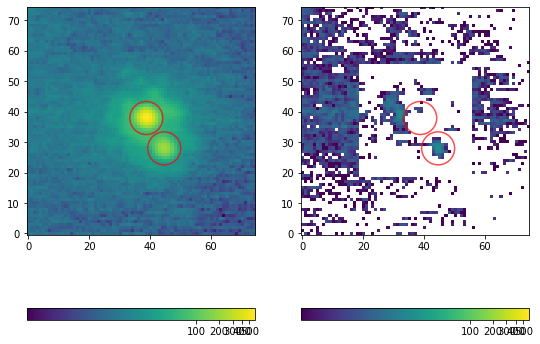

In [5]:
data_frames = []
for dataset in NIRC2_datasets[0:1]:
    data = []
    for image in dataset:
        phot_results = NIRCLocate(image, 100, 5, 5, stampsize=75, epsfstamp=75, roundness=0.5, iterations=2, crit_sep=10, setfwhm=False)
        data.append(phot_results)
    data2 = np.asarray(data)
    data_frames.append(pd.DataFrame(data=data2, columns=['sep','seperr','PA','PAerr']))

In [7]:
data_frames

[          sep    seperr          PA     PAerr
 0  114.917007  0.048648  210.239151  0.815677
 1  115.573423  0.101478  210.310862  0.709624
 2  114.897162  0.167039  210.498029  1.115728
 3  114.734075  0.078875  210.155624  0.970630
 4  114.502952  0.044752  210.115379  0.977884
 5  114.773908  0.056464  210.294537  0.964059
 6  115.473504  0.081638  210.186644  0.726702]

In [8]:
data_frames[0].to_clipboard()

In [3]:
results = pd.read_csv('IRAFStarfind_B2-B3.csv', nrows=16)

In [4]:
results.columns

Index(['Date', 'Filter 1', 'Filter 2', 'Name', 'Sep B2-B3', 'Sep Error',
       'Good sep', 'Sep goodness', 'Conserv sep Error', 'Avg PA B2-B3',
       'Avg PA Error', 'Good Pa', 'PA Goodness', 'Conserv PA Error',
       'Num imgs used', 'True Sep B2-B3', 'True Sep Error', 'True PA',
       'True PA err', 'do not delete, vestigial (had to copy from pdf)'],
      dtype='object')

In [5]:
results = results.drop([5,7,10])

In [6]:
results['datetime'] = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in results['Date']]
results['Epoch'] = [(x-results.datetime[0]).days for x in results.datetime]

In [7]:
from astropy.time import Time
results['MJD'] = [Time(x, format='datetime').mjd for x in results['datetime']]

In [8]:
np.zeros(len(results))+1

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
outtable = pd.DataFrame()
outtable['epoch'] = results['MJD']
outtable['object'] = np.zeros(len(results))+1
outtable['sep'] = results['Sep B2-B3']
outtable['sep_err'] = results['Sep Error']
outtable['pa'] = results['Avg PA B2-B3']
outtable['pa_err'] = results['Avg PA Error']
outtable.head()

,epoch,object,sep,sep_err,pa,pa_err
0,52263.0,1.0,114.980753,0.406738,210.256795,0.897230
1,53281.0,1.0,116.210375,0.300478,212.697247,-0.118090
2,53417.0,1.0,115.444214,0.343407,213.238768,0.542288
3,53426.0,1.0,114.995568,0.204996,212.981329,0.655344
4,55598.0,1.0,114.784870,0.204996,215.820127,1.643911


In [10]:
outtable.to_csv('B2-B3-orbitizetab.csv')

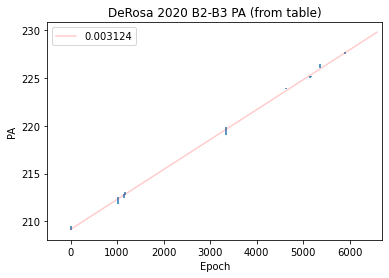

In [11]:
# DeRosa result
slope, intercept, r_value, p_value, std_err = stats.linregress(results['Epoch'][0:11], results['True PA'][0:11])
plt.errorbar(results['Epoch'], results['True PA'], yerr=results['True PA err'], ls='none')
plt.plot(results['Epoch'], intercept + slope*results['Epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
plt.xlim(-500, 6700)
plt.title('DeRosa 2020 B2-B3 PA (from table)')
plt.xlabel('Epoch')
plt.ylabel('PA')
plt.savefig('derosa_pa.png', dpq=200)

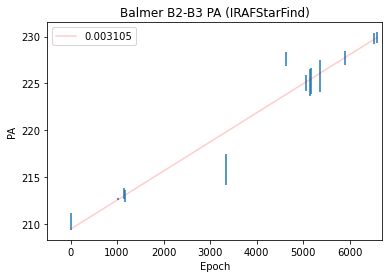

In [12]:
# my result
slope, intercept, r_value, p_value, std_err = stats.linregress(results['Epoch'], results['Avg PA B2-B3'])
plt.errorbar(results['Epoch'], results['Avg PA B2-B3'], yerr=results['Avg PA Error'], ls='none')
plt.plot(results['Epoch'], intercept + slope*results['Epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
plt.xlim(-500, 6700)
plt.title('Balmer B2-B3 PA (IRAFStarFind)')
plt.xlabel('Epoch')
plt.ylabel('PA')
plt.savefig('balmer_pa.png', dpq=200)

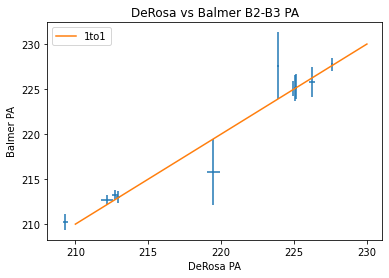

In [17]:
plt.errorbar(x=results['True PA'], y=results['Avg PA B2-B3'], xerr=results['True PA err'], yerr=results['Conserv PA Error'], ls='none')
plt.plot([210,230],[210,230], label='1to1')
plt.title('DeRosa vs Balmer B2-B3 PA')
plt.legend()
plt.xlabel('DeRosa PA')
plt.ylabel('Balmer PA')
plt.savefig('pa_compare.png', dpq=200)

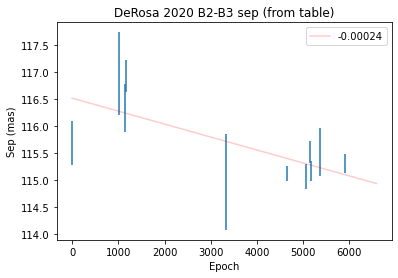

In [14]:
# DeRosa result for sep
slope, intercept, r_value, p_value, std_err = stats.linregress(results['Epoch'][0:11], results['True Sep B2-B3'][0:11])
plt.errorbar(results['Epoch'], results['True Sep B2-B3'], yerr=results['True Sep Error'], ls='none')
plt.plot(results['Epoch'], intercept + slope*results['Epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
# plt.xlim(-500, 6700)
plt.title('DeRosa 2020 B2-B3 sep (from table)')
plt.xlabel('Epoch')
plt.ylabel('Sep (mas)')
plt.savefig('derosa_sep.png', dpq=200)

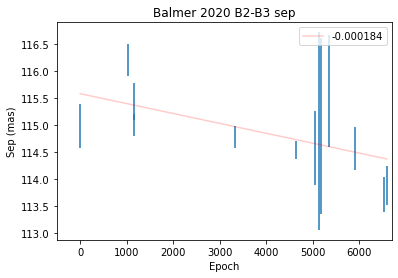

In [15]:
# my result
slope, intercept, r_value, p_value, std_err = stats.linregress(results['Epoch'], results['Sep B2-B3'])
plt.errorbar(results['Epoch'], results['Sep B2-B3'], yerr=results['Sep Error'], ls='none')
plt.plot(results['Epoch'], intercept + slope*results['Epoch'], 'r', alpha=0.2, label=round(slope,6))
plt.legend()
plt.xlim(-500, 6700)
plt.title('Balmer 2020 B2-B3 sep')
plt.xlabel('Epoch')
plt.ylabel('Sep (mas)')
plt.savefig('balmer_sep.png', dpq=200)

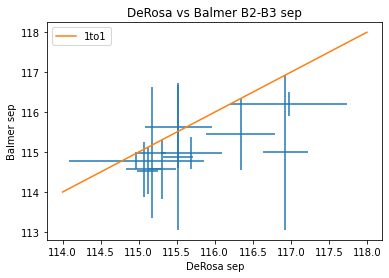

In [20]:
plt.errorbar(x=results['True Sep B2-B3'], y=results['Sep B2-B3'], xerr=results['True Sep Error'], yerr=results['Conserv sep Error'], ls='none')
plt.plot([114,118],[114,118], label='1to1')
plt.title('DeRosa vs Balmer B2-B3 sep')
plt.legend()
plt.xlabel('DeRosa sep')
plt.ylabel('Balmer sep')
plt.savefig('sep_compare.png', dpq=200)